# Exploring reconstruction data

Some notes.

1. Response times are not correct on stimulus/submission records and will need to be reconstructed
2. I find *no indication* that there are errors in the final submission. This leaves the weird indicator observations at position 0 to be explained, but it's clear they are not causing the board representation to be incorrect.

Some todos.

1. Count neighboring pieces at each position for each and both colors for error prediction
2. Look at distribution of errors by unique position.
3. Should probably do a more proper factor analysis rather than independent tests and regressions, but these are adequate (and clear!) enough for a first pass
4. **SUPER IMPORTANT** import real/fake records for all positions!


## Boilerplate

Imports and data loading.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import os

from lib.util import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('talk')

% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games/Data/4_rcn/Raw Data')
trained_files_dir = os.path.join(data_dir, 'Trained')
naive_files_dir = os.path.join(data_dir, 'Untrained')

all_files = get_all_csvs(trained_files_dir) + get_all_csvs(naive_files_dir)

DF = load_data(all_files)
DF = process_data(DF)

bpi, wpi, bpf, wpf = unpack_positions(DF)

black_errors = (bpf != bpi).astype(int)
white_errors = (wpf != wpi).astype(int)

## Compute errors

First extract positions as numpy arrays for easier manipulation

### Error types


- **Black**: differences in black boards
- **White**: differences in white boards
- **Type I**: "false positive"; putting a piece where there was not one
- **Type II**: "false negative"; neglecting a piece where there should have been one
- **Type III**: "swap"; switching the color on a piece

## Questions

### Are there errors in the board representation data?

Yunqi previously had trouble with some oddities in the board construction sequences where a piece would be placed in position 0 (top left corner), but the board representation didn't change.

**Answer**: 
- No sign that there are excessive errors at position 0; not sure what Yunqi did before...
- Does *not* explain the quesitionable records. They must be utility indicators for the server/client, but I haven't found where in the code they're being produced or why they're necessary. Something to follow up on, but not a practical problem; those records can simply be dropped.

In [3]:
black_errors_by_location = black_errors.sum(axis=1)
white_errors_by_location = white_errors.sum(axis=1)

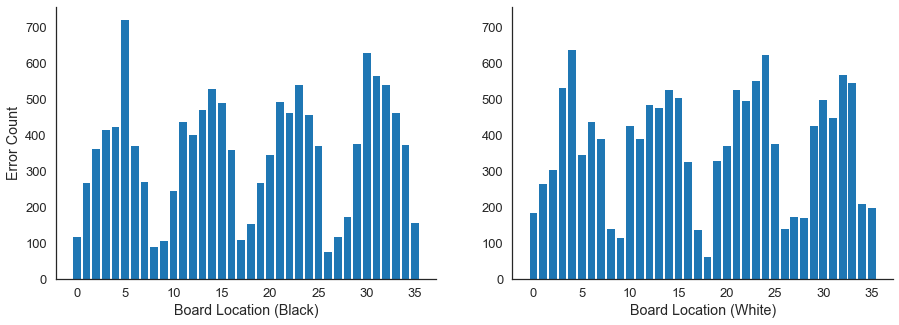

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), squeeze=False, sharex=True, sharey=True)

ax = axes[0, 0]
ax.bar(np.arange(36), black_errors_by_location)
plt.setp(ax, ylabel='Error Count', xlabel='Board Location (Black)')

ax = axes[0, 1]
ax.bar(np.arange(36), white_errors_by_location)
plt.setp(ax, xlabel='Board Location (White)')

sns.despine()

Just another very quick confirmation - there are *never* conflicts between pieces of different color in the final representation.

In [5]:
((bpf == 1) & (wpf == 1)).astype(int).sum()

0

### Are there differences in error rates between experts and non experts?

Answer: looks like yes to me, but has a complicated and significant relationship with the number of pieces. What's the correct analysis? Is this an ANOVA sort of thing for frequentists?

TODO: ELO rating effect for trained subjects?

In [6]:
piv = DF.pivot_table(index='Num Pieces', values='Total Errors', columns='Condition', margins=True, aggfunc=np.mean)
piv # just showing off pandas here

Condition,Naive,Trained,All
Num Pieces,,,
11,3.719298,3.342105,3.530702
12,4.092105,3.469298,3.780702
13,4.776316,4.478070,4.627193
14,6.456140,5.684211,6.070175
15,6.978070,6.456140,6.717105
16,7.776316,7.166667,7.471491
17,8.719298,8.328947,8.524123
18,8.627193,7.938596,8.282895
All,6.393092,5.858004,6.125548


Condition independent t-test:
 Ttest_indResult(statistic=-3.9286164111678126, pvalue=8.7018663725315566e-05) 


# Pieces vs Total Errors correlation

All: LinregressResult(slope=0.78764619883040932, intercept=-5.2953216374268992, rvalue=0.43795537927415945, pvalue=7.6052642377300263e-171, stderr=0.026776332169987354) 

Trained LinregressResult(slope=0.77751670843776111, intercept=-5.4159878863826236, rvalue=0.41734572213189186, pvalue=8.5862938917470562e-78, stderr=0.039662761303886906) 

Naive LinregressResult(slope=0.79777568922305775, intercept=-5.1746553884711801, rvalue=0.46284779209292032, pvalue=1.6611767029244807e-97, stderr=0.035794530307343191)


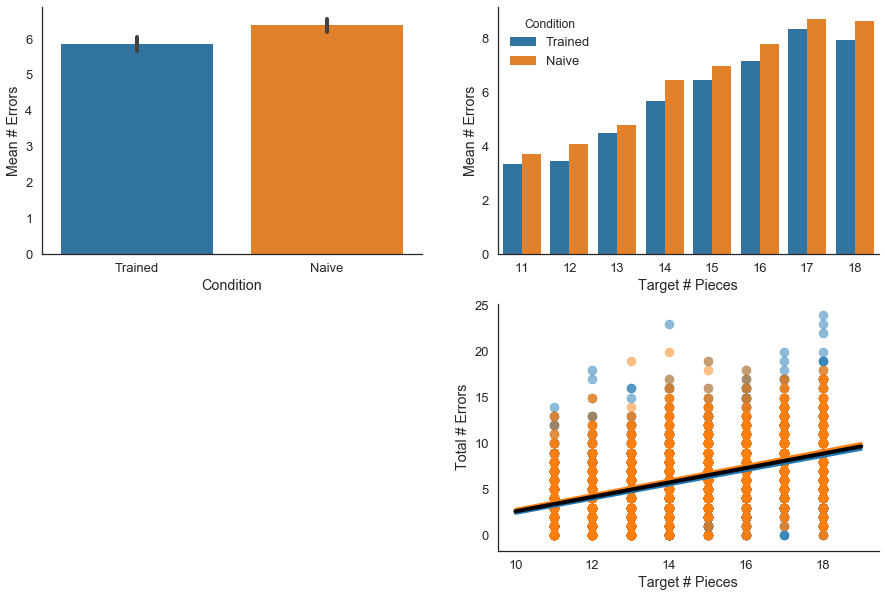

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), squeeze=False)

tr = DF.loc[DF['Condition'] == 'Trained']
na = DF.loc[DF['Condition'] == 'Naive']

ax = axes[0, 0]
sns.barplot(x='Condition', y='Total Errors', data=DF, ax=ax)
plt.setp(ax, ylabel='Mean # Errors')
ttest = sts.ttest_ind(tr['Total Errors'], na['Total Errors'])
print('Condition independent t-test:\n', ttest, '\n\n')

ax = axes[0, 1]
sns.barplot(x='Num Pieces', y='Total Errors', hue='Condition', data=DF, ax=ax, ci=None)
plt.setp(ax, xlabel='Target # Pieces', ylabel='Mean # Errors')

ax = axes[1, 1]

ax.scatter(tr['Num Pieces'], tr['Total Errors'], alpha=.5)
ax.scatter(na['Num Pieces'], na['Total Errors'], alpha=.5)
lr = sts.linregress(DF['Num Pieces'], DF['Total Errors'])
lr_tr = sts.linregress(tr['Num Pieces'], tr['Total Errors'])
lr_na = sts.linregress(na['Num Pieces'], na['Total Errors'])
print('# Pieces vs Total Errors correlation\n\nAll:', lr, '\n\nTrained', lr_tr, '\n\nNaive', lr_na)

x = np.arange(10, 20)
ax.plot(x, x * lr_tr.slope + lr_tr.intercept, linewidth=3)
ax.plot(x, x * lr_na.slope + lr_na.intercept, linewidth=3)
ax.plot(x, x * lr.slope + lr.intercept, color='black', linewidth=4)
plt.setp(ax, ylabel='Total # Errors', xlabel='Target # Pieces')

axes[1, 0].set_visible(False)

sns.despine()

### Are there different patterns for forgetting pieces, adding extras, and switching colors?

**Answer**: Yes, looks like it.

- More experienced players *may* be *slightly* more likely to add a piece where none previously existed
- More experienced players are substantially less likely to forget a piece
- More experienced players are somewhat less likely to get the color of a piece wrong

Type I Ttest:
 Ttest_indResult(statistic=2.0829104407523378, pvalue=0.037328912594820775) 

Type II Ttest:
 Ttest_indResult(statistic=-5.1225228229880369, pvalue=3.170965772659798e-07) 

Type III Ttest:
 Ttest_indResult(statistic=-3.8508961941492612, pvalue=0.00011970699502190505) 



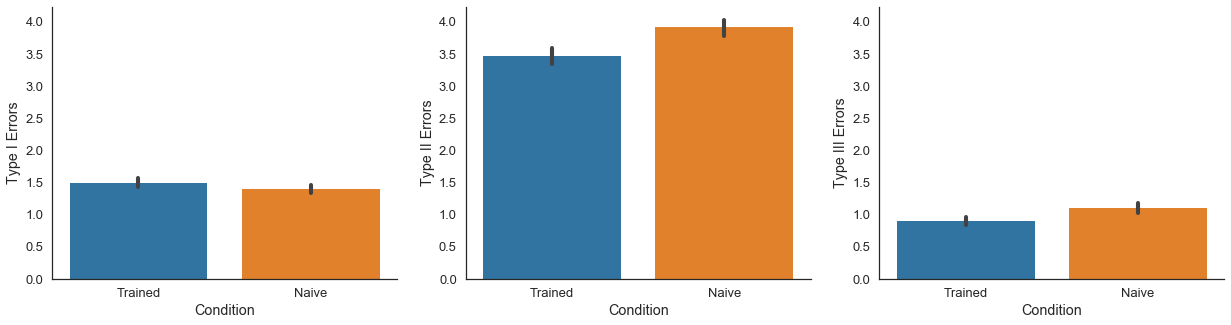

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5), squeeze=False, sharey=True)

ax = axes[0, 0]
sns.barplot(x='Condition', y='Type I Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type I Errors'], na['Type I Errors'])
print('Type I Ttest:\n', ttest, '\n')

ax = axes[0, 1]
sns.barplot(x='Condition', y='Type II Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type II Errors'], na['Type II Errors'])
print('Type II Ttest:\n', ttest, '\n')

ax = axes[0, 2]
sns.barplot(x='Condition', y='Type III Errors', data=DF, ax=ax)
ttest = sts.ttest_ind(tr['Type III Errors'], na['Type III Errors'])
print('Type III Ttest:\n', ttest, '\n')


sns.despine()

### How does error likelihood depend on location?

Bonferonni correction!!

The below could use some further clarity - looks like it has to do with distribution of stimuli as much as anything else. For example, could divide by number of times a piece is located at that position.

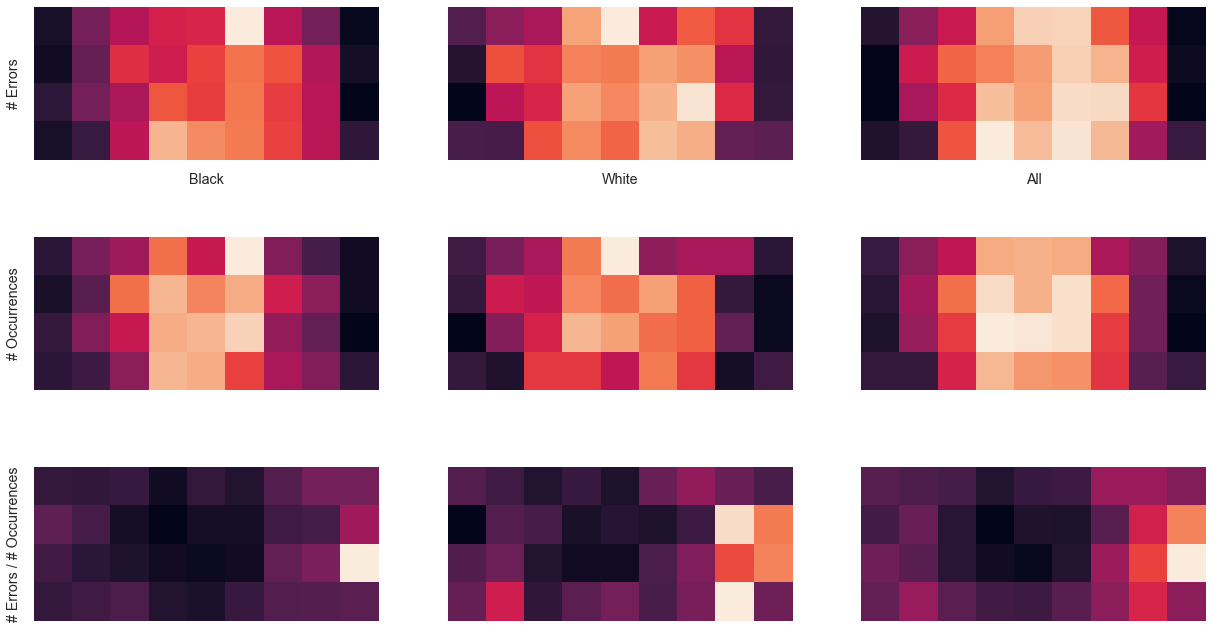

In [116]:
fig, axes = plt.subplots(3, 3, figsize=(21, 12), squeeze=False)
heatmap_kws = {'cbar': False, 'square': True}
heatmap = lambda data, ax: sns.heatmap(data.reshape([4, 9]), ax=ax, **heatmap_kws)

heatmap(black_errors_by_location, axes[0, 0])
heatmap(bpi.sum(axis=1), axes[1, 0])
heatmap(black_errors_by_location / bpi.sum(axis=1), axes[2, 0])
heatmap(white_errors_by_location, axes[0, 1])
heatmap(wpi.sum(axis=1), axes[1, 1])
heatmap(white_errors_by_location / wpi.sum(axis=1), axes[2, 1])
heatmap(black_errors_by_location + white_errors_by_location, axes[0, 2])
heatmap((bpi + wpi).sum(axis=1), axes[1, 2])
heatmap((black_errors_by_location + white_errors_by_location) / (bpi + wpi).sum(axis=1), axes[2, 2])

plt.setp(axes, yticklabels=[], xticklabels=[])
plt.setp(axes[0, 0], ylabel='# Errors', xlabel='Black')
plt.setp(axes[0, 1], xlabel='White')
plt.setp(axes[0, 2], xlabel='All')
plt.setp(axes[1, 0], ylabel='# Occurrences')
plt.setp(axes[2, 0], ylabel='# Errors / # Occurrences')

sns.despine(left=True, bottom=True)

### Is there an effect from real vs fake positions? Is there an interaction between position type and condition?

**Answer**: Yes effect; no interaction. It looks like the fake positions were substantially harder for *both* groups. This signals a substantial difference in basic statistics with the real and fake positions. (Eg, I think this is probably a hefty manipulation failure).

In [10]:
DF.pivot_table(index='Is Real', columns='Condition', values='Total Errors')

Condition,Naive,Trained
Is Real,,
False,7.449561,6.910088
True,5.336623,4.805921


In [112]:
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

smDF = pd.DataFrame(index=DF.index, columns=['target', 'f1', 'f2'])
smDF['target'] = DF['Total Errors']
smDF['f1'] = DF['Is Real']
smDF['f2'] = DF['Condition']

formula = 'target ~ C(f1) + C(f2) + C(f1):C(f2)'
model = ols(formula, smDF).fit()

anova_table = statsmodels.stats.anova.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(f1),4054.746711,1.0,256.382789,8.108954e-56
C(f2),261.122807,1.0,16.510869,4.939166e-05
C(f1):C(f2),0.017544,1.0,0.001109,9.734322e-01
Residual,57630.611842,3644.0,NaN,NaN


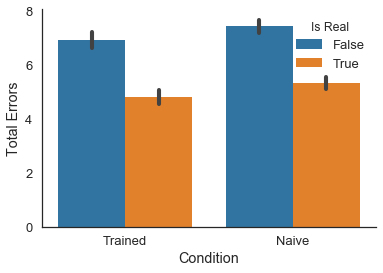

In [36]:
sns.barplot(x='Condition', y='Total Errors', hue='Is Real', data=DF)
sns.despine()

## Scrap

Make this into a standalone script at some point

In [19]:
with open('../etc/4 Reconstruction/stimuli.txt', mode='r') as f:
    positions = f.readlines()
    
def strip_position(position_string):
    s = [p.strip("'") for p in position_string.split('(')[1].split(')')[0].split(', ')[:2]]
    return s[0] + s[1]

stimuli = list(map(strip_position, positions))
fake_mask = np.ones(len(stimuli), dtype=int)
fake_mask[:len(stimuli)//2] = 0

stim_map = pd.DataFrame(index=stimuli, data=fake_mask.astype(bool), columns=['Is Real'])
stim_map['Position ID'] = np.arange(len(stim_map), dtype=int)
stim_map['Position dummy'] = stim_map.index
stim_map = stim_map.drop_duplicates(subset='Position dummy')
stim_map[['Is Real', 'Position ID']].to_csv('../etc/4 Reconstruction/position_map.csv', )

In [20]:
stim_map = pd.read_csv('../etc/4 Reconstruction/position_map.csv', index_col=0, skiprows=1, names=['Position', 'Is Real', 'Position ID'])